## Genome Space analysis of HUMAN ONT dataset after correction

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import joblib
import pysam
from tqdm import tqdm

sys.path.append("/lustrehome/afonzino")

from C_to_U_classifier_plus_min import utils
from C_to_U_classifier_plus_min.utils import create_sequence_logo, get_rev_compl

### --- utils functions --- ################
def retrieve_depth_stranded(bam_file, region, pos1based, strand):
    pos0based=pos1based-1
    for pileupcolumn in bam_file.pileup(region, pos0based, pos0based+1, truncate=True, max_depth=1000000, min_base_quality=0):
        column = pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True)
        if strand == "+":
            depth_stranded = sum(1 for b in column if b.isupper())
        elif strand == "-":
            depth_stranded = sum(1 for b in column if b.islower())
    return depth_stranded


def produce_consensus(df, title, interval, ref_filepath):
    with tqdm(total=df.shape[0]) as pbar:
        refs = []
        ref = pysam.FastaFile(ref_filepath)
        for site in df.itertuples():
            region = site[1]
            pos1based = site[2]
            pos0based = pos1based-1
            strand = site[3]
            reference = ref.fetch(region, pos0based-interval, pos0based+interval+1)
            if strand == "+":
                refs.append(list(reference))
            elif strand == "-":
                reference = get_rev_compl(reference)
                refs.append(list(reference))
            pbar.update(1)
    ref.close()
    
    refs = pd.DataFrame(refs, columns=[f"{i}" for i in range(interval*2+1)])
    refs_freqs = {}
    for rel_pos in refs:
        refs_freqs[int(rel_pos)] = refs[rel_pos].value_counts().sort_index()
    refs = pd.DataFrame(refs_freqs).fillna(0)
    depths = refs.sum().tolist()
    refs = refs / depths
    refs = refs.T

    create_sequence_logo(refs, title=f"{title}")

############################################

In [2]:
# load encoded datasets
paths = {"wt1":"/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_wt1.tsv",
         "wt4":"/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_wt4.tsv",
         "oxp1":"/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_oxp1.tsv",
         "oxp2":"/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_oxp2.tsv",
         "oxp3":"/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_oxp3.tsv",
         "oxp4":"/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_oxp4.tsv"}

dfCTs_enc = {}

for run in paths.keys():
    print(run)
    dfCTs_enc[run] = pd.read_table(paths[run])
    print(dfCTs_enc[run])
    print()

wt1
         region   position                             read_name strand  \
0          chr5     204977  b74a2e71-91a2-4b28-b84d-1d5b26a2d282      -   
1          chr5     205023  458ad779-c42b-4fae-ac0b-6a5697ea708c      -   
2          chr5     205023  086b13c3-b271-44af-bd2e-972b64080d33      -   
3          chr5     205023  8d77acb9-75ff-4895-9b66-c9b2b58edcb0      -   
4          chr5     205025  51c50891-27e3-4f42-a3d2-dc7fb58e69aa      -   
...         ...        ...                                   ...    ...   
11144175  chr13  113641456  8430698f-cdf0-4535-8b83-9dee216fa912      +   
11144176  chr13  113641456  8c11fa4a-53d3-4104-a554-50052ec11161      +   
11144177  chr13  113641456  d111dfc4-3e64-4e07-964c-62f415b7baf3      +   
11144178  chr13  113641456  6c83eada-d2c1-4397-9628-4d3f84b3bb7a      +   
11144179  chr13  113641456  dc978320-62f4-4601-b768-c35e173e6aa1      +   

          Tqual  MeanQual  n_mismatches  n_dels  n_ins  
0           2.0       7.3             

In [4]:
# aggregate to genome space before and after iForest correction
dfCTs_aggregated = {}

for run in dfCTs_enc.keys():
    # aggregate data on genome space before and after correction for both WT and OXPs samples
    dfCT_enc_genomespace_native = dfCTs_enc[run].groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
    # corrected are both without mism., indels and predicted as novelty by iforest
    
    dfCTs_aggregated[run] = dfCT_enc_genomespace_native
    print()
    print(run)
    print(dfCTs_aggregated[run])


wt1
        region  position strand  T_native
0         chr1    184949      -         1
1         chr1    184986      -         1
2         chr1    184994      -         4
3         chr1    185005      -         2
4         chr1    185056      -         2
...        ...       ...    ...       ...
1025815   chrY  57130183      +         3
1025816   chrY  57130226      +         1
1025817   chrY  57130245      +         2
1025818   chrY  57130247      +         5
1025819   chrY  57130253      +         2

[1025820 rows x 4 columns]

wt4
       region  position strand  T_native
0        chr1    630766      +         1
1        chr1    630776      +         4
2        chr1    630778      +        18
3        chr1    630781      +         1
4        chr1    630784      +         3
...       ...       ...    ...       ...
536624   chrY   2741200      +        18
536625   chrY   2741225      +        11
536626   chrY   2741228      +         1
536627   chrY   2741276      +         2
536628 

In [6]:
dfCTs_wt_aggregated_merged_native = pd.merge(dfCTs_aggregated["wt1"], dfCTs_aggregated["wt4"], how="outer")
dfCTs_wt_aggregated_merged_native

,region,position,strand,T_native
0,chr1,184949,-,1
1,chr1,184986,-,1
2,chr1,184994,-,4
3,chr1,185005,-,2
4,chr1,185056,-,2
...,...,...,...,...
1489210,chrY,2741200,+,18
1489211,chrY,2741225,+,11
1489212,chrY,2741228,+,1
1489213,chrY,2741276,+,2


In [7]:
dfCTs_wt_aggregated_merged_native.describe()

,position,T_native
count,1.489215e+06,1.489215e+06
mean,7.088197e+07,1.145833e+01
std,5.674696e+07,7.199517e+01
min,8.000000e+00,1.000000e+00
25%,2.874352e+07,1.000000e+00
50%,5.567877e+07,3.000000e+00
75%,1.077143e+08,7.000000e+00
max,2.467675e+08,1.351900e+04


In [8]:
dfCTs_wt_aggregated_merged_native.query("T_native > 1")

,region,position,strand,T_native
2,chr1,184994,-,4
3,chr1,185005,-,2
4,chr1,185056,-,2
6,chr1,185105,-,3
8,chr1,185111,-,6
...,...,...,...,...
1489208,chrY,2741194,+,7
1489209,chrY,2741197,+,8
1489210,chrY,2741200,+,18
1489211,chrY,2741225,+,11


In [9]:
dfCTs_wt_aggregated_merged_native.query("T_native > 2")

,region,position,strand,T_native
2,chr1,184994,-,4
6,chr1,185105,-,3
8,chr1,185111,-,6
14,chr1,185258,-,3
17,chr1,185495,-,4
...,...,...,...,...
1489205,chrY,2741175,+,7
1489208,chrY,2741194,+,7
1489209,chrY,2741197,+,8
1489210,chrY,2741200,+,18


In [10]:
dfCTs_wt_aggregated_merged_native.query("T_native > 10")

,region,position,strand,T_native
27,chr1,187210,-,17
39,chr1,629701,+,24
51,chr1,629833,+,18
70,chr1,630778,+,23
83,chr1,630827,+,27
...,...,...,...,...
1489197,chrY,2741111,+,21
1489198,chrY,2741112,+,16
1489200,chrY,2741138,+,11
1489210,chrY,2741200,+,18


In [6]:
# retrieve stranded depths for each position that, after filtering and correction, has at least one aligned CT-context read
bam_files_basepath = "/lustre/bio_running/conticello"

for run in dfCTs_aggregated.keys():
    print()
    print("Starting computations for run:", run)
    print("Retrieving only sites with at least 1 CT read after correction in order to spare computation time...")
    dfCTs_aggregated[run] = dfCTs_aggregated[run].query("T_corrected > 1")
    bam_filepath = os.path.join(bam_files_basepath, run, f"{run}.bam")
    print("Stranded depths are retrieved from bam file at path:", bam_filepath)
    # start computation
    bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
    depths_stranded = []
    # start computation
    bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
    depths_stranded = []
    with tqdm(total=dfCTs_aggregated[run].shape[0]) as pbar:
        for s in dfCTs_aggregated[run].itertuples():
            try:
                d = retrieve_depth_stranded(bam, s.region, s.position, s.strand)
            except UnboundLocalError:
                d = 0
            depths_stranded.append(d)
            pbar.update(1)
    bam.close()
    # append depths_stranded columns to final dataframe of aggregated data
    dfCTs_aggregated[run]["depth_stranded"] = depths_stranded
    # retain only sites with a depth higher than 50
    dfCTs_aggregated[run] = dfCTs_aggregated[run].query("depth_stranded > 50").fillna(0)
    # produce frequencies
    dfCTs_aggregated[run]["Tfreq_native"] = dfCTs_aggregated[run]["T_native"] / dfCTs_aggregated[run]["depth_stranded"]
    dfCTs_aggregated[run]["Tfreq_corrected"] = dfCTs_aggregated[run]["T_corrected"] / dfCTs_aggregated[run]["depth_stranded"]
    print(f"\n{run}\n", dfCTs_aggregated[run])


Starting computations for run: wt1
Retrieving only sites with at least 1 CT read after correction in order to spare computation time...
Stranded depths are retrieved from bam file at path: /lustre/bio_running/conticello/wt1/wt1.bam


100%|██████████| 13694/13694 [43:00<00:00,  5.31it/s]  



wt1
         region  position strand  T_native  T_corrected  depth_stranded  \
22        chr1    186428      -         8          3.0              51   
85        chr1    630832      +       163         76.0             225   
266       chr1    944249      -        12          2.0             295   
276       chr1    944297      -        72          2.0             257   
359       chr1    944498      -        36          4.0             317   
...        ...       ...    ...       ...          ...             ...   
1025329   chrY   1387286      -        17          3.0             769   
1025497   chrY   1389695      -        33          2.0             748   
1025593   chrY   2691346      +        20          2.0             216   
1025665   chrY   2726266      +        13          5.0             208   
1025672   chrY   2726308      +        57          2.0             252   

         Tfreq_native  Tfreq_corrected  
22           0.156863         0.058824  
85           0.724444  

100%|██████████| 7523/7523 [33:28<00:00,  3.75it/s]



wt4
        region  position strand  T_native  T_corrected  depth_stranded  \
13       chr1    630832      +       114         49.0             166   
234      chr1    944419      -         4          2.0             126   
270      chr1    944498      -        19          2.0             126   
423      chr1    999124      -        52          5.0             212   
599      chr1   1000018      -        34         10.0             159   
...       ...       ...    ...       ...          ...             ...   
536189   chrY   1386605      -        49          2.0             390   
536209   chrY   1386689      -        25          2.0             345   
536235   chrY   1387328      -        32          2.0             239   
536399   chrY   1391907      -        60          3.0             319   
536625   chrY   2741225      +        11          4.0             125   

        Tfreq_native  Tfreq_corrected  
13          0.686747         0.295181  
234         0.031746         0.015873

100%|██████████| 3971/3971 [02:58<00:00, 22.19it/s] 



oxp1
        region   position strand  T_native  T_corrected  depth_stranded  \
132      chr1     999124      -        67          2.0             281   
158      chr1     999183      -        51          2.0             262   
355      chr1    1000018      -        54         15.0             201   
647      chr1    1309790      +         8          2.0              73   
778      chr1    1373819      -        35          4.0             101   
...       ...        ...    ...       ...          ...             ...   
182237   chrX  155033490      +         8          2.0              52   
182372   chrY    1386398      -        42          2.0             206   
182446   chrY    1386689      -        15          2.0             173   
182607   chrY    1389695      -        18          2.0             174   
182682   chrY    1392076      -        44          2.0             160   

        Tfreq_native  Tfreq_corrected  
132         0.238434         0.007117  
158         0.194656    

100%|██████████| 4979/4979 [06:03<00:00, 13.71it/s]



oxp2
        region  position strand  T_native  T_corrected  depth_stranded  \
9        chr1    630832      +        41         16.0              60   
164      chr1    944717      -         7          2.0             131   
514      chr1    999080      -        19          3.0             273   
531      chr1    999124      -        77          4.0             342   
551      chr1    999170      -        15          4.0             231   
...       ...       ...    ...       ...          ...             ...   
270622   chrY   1386571      -        23          2.0             320   
270661   chrY   1386716      -        57          2.0             337   
270672   chrY   1387286      -        16          4.0             532   
270684   chrY   1387328      -        27          2.0             314   
270845   chrY   1389695      -        34          4.0             495   

        Tfreq_native  Tfreq_corrected  
9           0.683333         0.266667  
164         0.053435         0.01526

100%|██████████| 727/727 [00:56<00:00, 12.90it/s] 



oxp3
       region   position strand  T_native  T_corrected  depth_stranded  \
26      chr1    6186681      -         7          3.0             149   
51      chr1    6192962      -        38          2.0             143   
127     chr1    8861234      -        33          2.0             295   
190     chr1    8862920      -        46          8.0             270   
233     chr1    8863972      -         7          3.0             245   
...      ...        ...    ...       ...          ...             ...   
33764   chrX  119786564      -        28          3.0             330   
33769   chrX  119786583      -        45          4.0             322   
33873   chrX  153796459      +        21          2.0             100   
34013   chrX  154399490      +         7          5.0             574   
34031   chrX  154399589      +       149          2.0             532   

       Tfreq_native  Tfreq_corrected  
26         0.046980         0.020134  
51         0.265734         0.013986  

100%|██████████| 1128/1128 [02:16<00:00,  8.26it/s]


oxp4
       region   position strand  T_native  T_corrected  depth_stranded  \
62      chr1     999193      -         8          2.0              57   
139     chr1    6186681      -        13          3.0             220   
140     chr1    6186699      -         7          3.0             220   
178     chr1    6197662      -        36          3.0             211   
402     chr1    8862920      -        53         11.0             395   
...      ...        ...    ...       ...          ...             ...   
54016   chrX  154400500      +        37          3.0             816   
54049   chrX  154400710      +        38          2.0             598   
54066   chrX  154400800      +        23          2.0             842   
54095   chrX  154400879      +        56          2.0             670   
54100   chrX  154400900      +       135          3.0             640   

       Tfreq_native  Tfreq_corrected  
62         0.140351         0.035088  
139        0.059091         0.013636  


/tmp/ipykernel_117022/3530490138.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCTs_aggregated[run]["depth_stranded"] = depths_stranded


In [12]:
# takes only sites with a frequency higher than at least 0.01 after the correction and save them to disk (and with more than 1 CT reads after correction)
# CtoU editing sites candidates

dfCTs_aggregated_candidates = {}

for dfCT_aggregated in dfCTs_aggregated.keys():
    print()
    print(dfCT_aggregated)
    dfCTs_aggregated_candidates[dfCT_aggregated] = dfCTs_aggregated[dfCT_aggregated].query("Tfreq_corrected > 0.01")
    print(f"\n{dfCT_aggregated} CtoU editing site candidates\n", dfCTs_aggregated_candidates[dfCT_aggregated])
    
    # save to disk
    dfCTs_aggregated_candidates[dfCT_aggregated].to_csv(f"/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_{dfCT_aggregated}_aggregated_candidates.tsv",
                                                        sep="\t",
                                                        index=None)


wt1

wt1 CtoU editing site candidates
         region   position strand  T_native  T_corrected  depth_stranded  \
22        chr1     186428      -         8          3.0              51   
85        chr1     630832      +       163         76.0             225   
359       chr1     944498      -        36          4.0             317   
468       chr1     946247      -        57         11.0             213   
646       chr1     952544      -         9          2.0             159   
...        ...        ...    ...       ...          ...             ...   
1024888   chrX  155239146      +        12          4.0             375   
1024908   chrX  155239291      +        37          4.0             376   
1024968   chrX  155239711      +        87          5.0             335   
1025020   chrY     305038      -        32         10.0              56   
1025665   chrY    2726266      +        13          5.0             208   

         Tfreq_native  Tfreq_corrected  
22           0.156

In [168]:
# merge datasets of OXPs samples
# merge oxp1 and oxp2
dfCT_oxp_aggregated_candidates_merged = pd.merge(dfCTs_aggregated_candidates["oxp1"],
                                                 dfCTs_aggregated_candidates["oxp2"],
                                                 how="outer",
                                                 on=["region", "position", "strand"],
                                                 suffixes=["_oxp1", "_oxp2"])
# merge oxp1-2 and oxp3 and update columns
dfCT_oxp_aggregated_candidates_merged = pd.merge(dfCT_oxp_aggregated_candidates_merged,
                                                 dfCTs_aggregated_candidates["oxp3"],
                                                 how="outer",
                                                 on=["region", "position", "strand"])
dfCT_oxp_aggregated_candidates_merged.columns = dfCT_oxp_aggregated_candidates_merged.columns[:-5].tolist() + [i+"_oxp3" for i in dfCT_oxp_aggregated_candidates_merged.columns[-5:]]

# merge oxp1-2-3 and oxp4 and update columns
dfCT_oxp_aggregated_candidates_merged = pd.merge(dfCT_oxp_aggregated_candidates_merged,
                                                 dfCTs_aggregated_candidates["oxp4"],
                                                 how="outer",
                                                 on=["region", "position", "strand"])
dfCT_oxp_aggregated_candidates_merged.columns = dfCT_oxp_aggregated_candidates_merged.columns[:-5].tolist() + [i+"_oxp4" for i in dfCT_oxp_aggregated_candidates_merged.columns[-5:]]

# retrieve only sites supported by at least 2 out 4 samples in oxp genotype
max_nans = 2
output = []
for c,candidate in enumerate(dfCT_oxp_aggregated_candidates_merged.fillna(-1).itertuples()):
    vector = [candidate.Tfreq_corrected_oxp1, candidate.Tfreq_corrected_oxp2, candidate.Tfreq_corrected_oxp3, candidate.Tfreq_corrected_oxp4]
    if vector.count(-1) <= max_nans:
        output.append([candidate.region, candidate.position, candidate.strand])
output = pd.DataFrame(output, columns=["region", "position", "strand"])

# create a final dataset of sites supported by at least 2 out 4 OXP runs and with freq. > 0.01 after iForest correction
dfCT_oxp_aggregated_candidates_merged = pd.merge(dfCT_oxp_aggregated_candidates_merged, output, how="inner")

print(dfCT_oxp_aggregated_candidates_merged)

    region  position strand  T_native_oxp1  T_corrected_oxp1  \
0     chr1   1000018      -           54.0              15.0   
1     chr1   1373819      -           35.0               4.0   
2     chr1   6186681      -           67.0              20.0   
3     chr1   6186699      -           71.0              12.0   
4     chr1   6197662      -          121.0               7.0   
..     ...       ...    ...            ...               ...   
652  chr16  30067538      +            NaN               NaN   
653  chr17   8377549      -            NaN               NaN   
654  chr17  39204567      +            NaN               NaN   
655  chr19  46838464      -            NaN               NaN   
656   chr2  61869457      -            NaN               NaN   

     depth_stranded_oxp1  Tfreq_native_oxp1  Tfreq_corrected_oxp1  \
0                  201.0           0.268657              0.074627   
1                  101.0           0.346535              0.039604   
2                  559.0

'# compute mean of T and Tfreqs before and after correction\ndfCT_oxp_aggregated_candidates_merged["T_native_mean"] = (dfCT_oxp_aggregated_candidates_merged["T_native_oxp1"]+dfCT_oxp_aggregated_candidates_merged["T_native_oxp2"]+dfCT_oxp_aggregated_candidates_merged["T_native_oxp3"]+dfCT_oxp_aggregated_candidates_merged["T_native_oxp4"])/4\ndfCT_oxp_aggregated_candidates_merged["T_corrected_mean"] = (dfCT_oxp_aggregated_candidates_merged["T_corrected_oxp1"]+dfCT_oxp_aggregated_candidates_merged["T_corrected_oxp2"]+dfCT_oxp_aggregated_candidates_merged["T_corrected_oxp3"]+dfCT_oxp_aggregated_candidates_merged["T_corrected_oxp4"])/4\ndfCT_oxp_aggregated_candidates_merged["Tfreq_native_mean"] = (dfCT_oxp_aggregated_candidates_merged["Tfreq_native_oxp1"]+dfCT_oxp_aggregated_candidates_merged["Tfreq_native_oxp2"]+dfCT_oxp_aggregated_candidates_merged["Tfreq_native_oxp3"]+dfCT_oxp_aggregated_candidates_merged["Tfreq_native_oxp4"])/4\ndfCT_oxp_aggregated_candidates_merged["Tfreq_corrected_mea

In [169]:
dfCT_oxp_aggregated_candidates_merged.describe()

,position,T_native_oxp1,T_corrected_oxp1,depth_stranded_oxp1,Tfreq_native_oxp1,Tfreq_corrected_oxp1,T_native_oxp2,T_corrected_oxp2,depth_stranded_oxp2,Tfreq_native_oxp2,...,T_native_oxp3,T_corrected_oxp3,depth_stranded_oxp3,Tfreq_native_oxp3,Tfreq_corrected_oxp3,T_native_oxp4,T_corrected_oxp4,depth_stranded_oxp4,Tfreq_native_oxp4,Tfreq_corrected_oxp4
count,6.570000e+02,577.000000,577.000000,577.000000,577.000000,577.000000,549.000000,549.000000,549.000000,549.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,7.085448e+07,114.455806,14.958406,390.561525,0.320723,0.055764,163.974499,26.783242,616.755920,0.293526,...,62.042453,9.674528,242.674528,0.220186,0.050716,68.025806,9.458065,254.877419,0.248031,0.050162
std,5.479719e+07,258.679912,31.303981,595.190606,0.239215,0.075589,409.385603,64.961769,1113.991619,0.259049,...,177.305405,18.182141,460.942701,0.203458,0.067281,218.503351,19.786805,594.101893,0.221011,0.061889
min,3.066000e+03,4.000000,2.000000,51.000000,0.026178,0.010033,2.000000,2.000000,51.000000,0.011561,...,2.000000,2.000000,51.000000,0.013889,0.010050,2.000000,2.000000,51.000000,0.017751,0.010204
25%,3.006897e+07,23.000000,3.000000,97.000000,0.146893,0.017937,21.000000,4.000000,130.000000,0.111371,...,11.000000,3.000000,77.750000,0.084862,0.018101,13.000000,3.000000,74.000000,0.100974,0.018626
50%,5.664394e+07,45.000000,6.000000,173.000000,0.244444,0.029197,58.000000,9.000000,259.000000,0.194444,...,22.500000,4.000000,149.500000,0.161081,0.029740,23.500000,4.000000,127.000000,0.177639,0.029889
75%,1.006784e+08,105.000000,15.000000,368.000000,0.426786,0.056911,151.000000,26.000000,569.000000,0.364606,...,47.500000,8.000000,288.000000,0.282248,0.052729,48.000000,8.000000,269.500000,0.313889,0.051173
max,2.317135e+08,3495.000000,441.000000,5258.000000,0.982759,0.615108,5694.000000,888.000000,11329.000000,1.000000,...,1954.000000,116.000000,6250.000000,0.975089,0.538462,2971.000000,165.000000,9425.000000,0.952038,0.388889


In [170]:
# merge also wt samples
# merge wt1 and wt4
dfCT_wt_aggregated_candidates_merged = pd.merge(dfCTs_aggregated_candidates["wt1"],
                                                dfCTs_aggregated_candidates["wt4"],
                                                how="outer",
                                                on=["region", "position", "strand"],
                                                suffixes=["_wt1", "_wt4"])
print(dfCT_wt_aggregated_candidates_merged.shape)

(6883, 13)


'# compute mean of T and Tfreqs before and after correction\ndfCT_wt_aggregated_candidates_merged["T_native_mean"] = (dfCT_wt_aggregated_candidates_merged["T_native_wt1"]+dfCT_wt_aggregated_candidates_merged["T_native_wt4"])/2\ndfCT_wt_aggregated_candidates_merged["T_corrected_mean"] = (dfCT_wt_aggregated_candidates_merged["T_corrected_wt1"]+dfCT_wt_aggregated_candidates_merged["T_corrected_wt4"])/2\ndfCT_wt_aggregated_candidates_merged["Tfreq_native_mean"] = (dfCT_wt_aggregated_candidates_merged["Tfreq_native_wt1"]+dfCT_wt_aggregated_candidates_merged["Tfreq_native_wt4"])/2\ndfCT_wt_aggregated_candidates_merged["Tfreq_corrected_mean"] = (dfCT_wt_aggregated_candidates_merged["Tfreq_corrected_wt1"]+dfCT_wt_aggregated_candidates_merged["Tfreq_corrected_wt4"])/2\ndfCT_wt_aggregated_candidates_merged'

In [171]:
dfCT_wt_aggregated_candidates_merged.describe()

,position,T_native_wt1,T_corrected_wt1,depth_stranded_wt1,Tfreq_native_wt1,Tfreq_corrected_wt1,T_native_wt4,T_corrected_wt4,depth_stranded_wt4,Tfreq_native_wt4,Tfreq_corrected_wt4
count,6.883000e+03,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,7.381879e+07,76.219756,12.331454,280.721848,0.259097,0.048596,64.568414,9.582029,240.445541,0.255402,0.044640
std,5.657658e+07,315.422468,56.054825,820.320072,0.206579,0.074593,208.925923,36.596795,550.321210,0.205016,0.068068
min,5.007000e+03,2.000000,2.000000,51.000000,0.011429,0.010004,2.000000,2.000000,51.000000,0.012500,0.010033
25%,3.114205e+07,14.000000,2.000000,84.000000,0.120078,0.015504,14.000000,2.000000,81.250000,0.121632,0.015504
50%,5.968561e+07,26.000000,3.000000,132.000000,0.200000,0.025000,25.000000,3.000000,126.000000,0.194854,0.024117
75%,1.108927e+08,54.000000,7.000000,214.000000,0.324873,0.041667,50.000000,6.000000,196.000000,0.312500,0.038462
max,2.467591e+08,10413.000000,1837.000000,19855.000000,1.000000,0.756098,4911.000000,1063.000000,11280.000000,1.000000,0.647619


In [172]:
# retrieve most reliable oxp edited sites filtering
# out sites with editing evidence in oxp after correction but without editing evidence in wt (no apobec1 gene expression)

reliable_sites = []
with tqdm(total=dfCT_oxp_aggregated_candidates_merged.shape[0]) as pbar:    
    for candidate in dfCT_oxp_aggregated_candidates_merged.itertuples():
        # exclude site called as edited in wt1 after correction
        if dfCT_wt_aggregated_candidates_merged.query(f"region == '{candidate.region}'").query(f"position == {candidate.position}").query(f"strand == '{candidate.strand}'").empty:
            # assess if the wt1 sample was covered by minimum depth of 50
            reliable_sites.append(list(candidate)[1:])
        
        pbar.update(1)
reliable_sites = pd.DataFrame(reliable_sites, columns=dfCT_oxp_aggregated_candidates_merged.columns)
reliable_sites

100%|██████████| 657/657 [00:02<00:00, 301.82it/s]


,region,position,strand,T_native_oxp1,T_corrected_oxp1,depth_stranded_oxp1,Tfreq_native_oxp1,Tfreq_corrected_oxp1,T_native_oxp2,T_corrected_oxp2,...,T_native_oxp3,T_corrected_oxp3,depth_stranded_oxp3,Tfreq_native_oxp3,Tfreq_corrected_oxp3,T_native_oxp4,T_corrected_oxp4,depth_stranded_oxp4,Tfreq_native_oxp4,Tfreq_corrected_oxp4
0,chr1,6186681,-,67.0,20.0,559.0,0.119857,0.035778,NaN,NaN,...,7.0,3.0,149.0,0.046980,0.020134,13.0,3.0,220.0,0.059091,0.013636
1,chr1,6186699,-,71.0,12.0,556.0,0.127698,0.021583,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.0,3.0,220.0,0.031818,0.013636
2,chr1,17018869,-,34.0,12.0,94.0,0.361702,0.127660,17.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,25900600,-,10.0,2.0,187.0,0.053476,0.010695,6.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,25900608,-,33.0,3.0,187.0,0.176471,0.016043,25.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,chr12,21644102,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,2.0,83.0,0.120482,0.024096,16.0,2.0,139.0,0.115108,0.014388
292,chr12,54282272,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,2.0,114.0,0.061404,0.017544,16.0,2.0,149.0,0.107383,0.013423
293,chr12,112405999,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.0,3.0,282.0,0.085106,0.010638,36.0,5.0,396.0,0.090909,0.012626
294,chr17,8377549,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.0,5.0,311.0,0.067524,0.016077,24.0,5.0,433.0,0.055427,0.011547


In [173]:
ref_filepath = "/lustre/bio_running/refs/GRCh38.primary_assembly.genome.filtered.fa"
ref = pysam.FastaFile(ref_filepath)
kmers = []
for site in reliable_sites.itertuples():
    kmer = ref.fetch(site.region, site.position-3, site.position+2)
    if site.strand == "+":
        kmers.append(kmer)
    elif site.strand == "-":
        kmers.append(utils.get_rev_compl(kmer))
ref.close()
reliable_sites["5mer"] = kmers

In [174]:
reliable_sites

,region,position,strand,T_native_oxp1,T_corrected_oxp1,depth_stranded_oxp1,Tfreq_native_oxp1,Tfreq_corrected_oxp1,T_native_oxp2,T_corrected_oxp2,...,T_corrected_oxp3,depth_stranded_oxp3,Tfreq_native_oxp3,Tfreq_corrected_oxp3,T_native_oxp4,T_corrected_oxp4,depth_stranded_oxp4,Tfreq_native_oxp4,Tfreq_corrected_oxp4,5mer
0,chr1,6186681,-,67.0,20.0,559.0,0.119857,0.035778,NaN,NaN,...,3.0,149.0,0.046980,0.020134,13.0,3.0,220.0,0.059091,0.013636,GACGA
1,chr1,6186699,-,71.0,12.0,556.0,0.127698,0.021583,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,3.0,220.0,0.031818,0.013636,GACGA
2,chr1,17018869,-,34.0,12.0,94.0,0.361702,0.127660,17.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TGCTA
3,chr1,25900600,-,10.0,2.0,187.0,0.053476,0.010695,6.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GACTT
4,chr1,25900608,-,33.0,3.0,187.0,0.176471,0.016043,25.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TGCTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,chr12,21644102,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,83.0,0.120482,0.024096,16.0,2.0,139.0,0.115108,0.014388,TTCTG
292,chr12,54282272,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,114.0,0.061404,0.017544,16.0,2.0,149.0,0.107383,0.013423,GACGA
293,chr12,112405999,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,282.0,0.085106,0.010638,36.0,5.0,396.0,0.090909,0.012626,CACAC
294,chr17,8377549,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,311.0,0.067524,0.016077,24.0,5.0,433.0,0.055427,0.011547,TACAA


100%|██████████| 296/296 [00:00<00:00, 30890.35it/s]


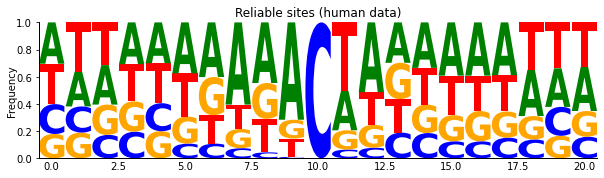

In [175]:
# produce consensus
produce_consensus(reliable_sites, "Reliable sites (human data)", 10, ref_filepath)

In [176]:
# annotate with annovar
# lets produce a file to be annotated by annovar
output_filepaht = "/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.vcf"
with open(output_filepaht, "w") as out_vcf:
    for s in reliable_sites.itertuples():
        region = s.region.split("chr")[1]
        position = s.position
        strand = s.strand
        REF="C"
        ALT="T"
        if strand == "-": # cause of VCF file strand-less structure
            REF="G"
            ALT="A"
        site = f"{region}\t{position}\t{position}\t{REF}\t{ALT}\n"
        out_vcf.write(site)

!cat /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.vcf | head

1	6186681	6186681	G	A
1	6186699	6186699	G	A
1	17018869	17018869	G	A
1	25900600	25900600	G	A
1	25900608	25900608	G	A
1	25900670	25900670	G	A
1	28237967	28237967	C	T
1	31908702	31908702	G	A
1	42696738	42696738	C	T
1	42702093	42702093	C	T


In [177]:
# annotate vcf
!/lustrehome/afonzino/annovar/table_annovar.pl /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.vcf /lustrehome/afonzino/annovar/humandb/ -buildver hg38 -out /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.annotated -protocol refGene -operation g -nastring . --remove -polish

-----------------------------------------------------------------
NOTICE: Processing operation=g protocol=refGene

NOTICE: Running with system command <annotate_variation.pl -geneanno -buildver hg38 -dbtype refGene -outfile /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.annotated.refGene -exonsort -nofirstcodondel /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.vcf /lustrehome/afonzino/annovar/humandb/>
NOTICE: Output files are written to /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.annotated.refGene.variant_function, /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatche

In [178]:
# load annotation and merge to reliable sites
reliable_sites_annotated = pd.concat([reliable_sites, 
                                      pd.read_table("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.annotated.hg38_multianno.txt")], 
                                      axis=1).drop(["Chr", "Start", "End"], axis=1)
reliable_sites_annotated

,region,position,strand,T_native_oxp1,T_corrected_oxp1,depth_stranded_oxp1,Tfreq_native_oxp1,Tfreq_corrected_oxp1,T_native_oxp2,T_corrected_oxp2,...,Tfreq_native_oxp4,Tfreq_corrected_oxp4,5mer,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene
0,chr1,6186681,-,67.0,20.0,559.0,0.119857,0.035778,NaN,NaN,...,0.059091,0.013636,GACGA,G,A,exonic,RPL22,.,synonymous SNV,RPL22:NM_000983:exon4:c.C378T:p.D126D
1,chr1,6186699,-,71.0,12.0,556.0,0.127698,0.021583,NaN,NaN,...,0.031818,0.013636,GACGA,G,A,exonic,RPL22,.,synonymous SNV,RPL22:NM_000983:exon4:c.C360T:p.D120D
2,chr1,17018869,-,34.0,12.0,94.0,0.361702,0.127660,17.0,6.0,...,NaN,NaN,TGCTA,G,A,UTR3,SDHB,NM_003000:c.*12C>T,.,.
3,chr1,25900600,-,10.0,2.0,187.0,0.053476,0.010695,6.0,3.0,...,NaN,NaN,GACTT,G,A,UTR3,STMN1,NM_203401:c.*416C>T;NM_005563:c.*416C>T;NM_203...,.,.
4,chr1,25900608,-,33.0,3.0,187.0,0.176471,0.016043,25.0,3.0,...,NaN,NaN,TGCTA,G,A,UTR3,STMN1,NM_203401:c.*408C>T;NM_005563:c.*408C>T;NM_203...,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,chr12,21644102,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.115108,0.014388,TTCTG,G,A,exonic,LDHB,.,nonsynonymous SNV,"LDHB:NM_001174097:exon4:c.C254T:p.S85F,LDHB:NM..."
292,chr12,54282272,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.107383,0.013423,GACGA,C,T,exonic,HNRNPA1,.,synonymous SNV,"HNRNPA1:NM_002136:exon4:c.C462T:p.D154D,HNRNPA..."
293,chr12,112405999,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.090909,0.012626,CACAC,G,A,exonic,RPL6,.,nonsynonymous SNV,"RPL6:NM_000970:exon6:c.C568T:p.H190Y,RPL6:NM_0..."
294,chr17,8377549,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.055427,0.011547,TACAA,G,A,UTR3,RPL26,NM_000987:c.*15C>T;NM_001315530:c.*15C>T;NM_00...,.,.


In [179]:
# save reliable annotated edited sites
reliable_sites_annotated.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.tsv", 
                                sep="\t",
                                index=None)

In [180]:
# remove not useful files generated for the annotation
!rm /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.vcf
!rm /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/reliable_ed_pos_human_data.annotated.hg38_multianno.txt

In [181]:
reliable_sites_annotated["Func.refGene"].value_counts()

UTR3              154
exonic             94
ncRNA_exonic       17
intergenic         13
intronic            8
ncRNA_intronic      6
UTR5                2
downstream          2
Name: Func.refGene, dtype: int64

In [182]:
reliable_sites_annotated["Gene.refGene"].value_counts()

H3P6               10
TPT1                8
LINC01787;PTBP2     6
HNRNPA1             5
H2AZ1               5
                   ..
RAB5C               1
EIF5A               1
APRT                1
NUTF2               1
RPL19               1
Name: Gene.refGene, Length: 177, dtype: int64

In [183]:
reliable_sites_annotated["ExonicFunc.refGene"].value_counts()

.                    202
synonymous SNV        48
nonsynonymous SNV     39
stopgain               7
Name: ExonicFunc.refGene, dtype: int64

In [184]:
reliable_sites_annotated[reliable_sites_annotated["ExonicFunc.refGene"]=="stopgain"]

,region,position,strand,T_native_oxp1,T_corrected_oxp1,depth_stranded_oxp1,Tfreq_native_oxp1,Tfreq_corrected_oxp1,T_native_oxp2,T_corrected_oxp2,...,Tfreq_native_oxp4,Tfreq_corrected_oxp4,5mer,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene
12,chr1,44778033,+,272.0,39.0,2618.0,0.103896,0.014897,NaN,NaN,...,NaN,NaN,AACGA,C,T,exonic,RPS8,.,stopgain,RPS8:NM_001012:exon5:c.C421T:p.R141X
18,chr1,92833586,+,187.0,17.0,1049.0,0.178265,0.016206,14.0,2.0,...,0.092784,0.018041,TACAA,C,T,exonic,RPL5,.,stopgain,RPL5:NM_000969:exon3:c.C115T:p.Q39X
61,chr12,7652507,-,184.0,6.0,558.0,0.329749,0.010753,NaN,NaN,...,0.212766,0.010638,ATCAA,G,A,exonic,APOBEC1,.,stopgain,"APOBEC1:NM_005889:exon2:c.C238T:p.Q80X,APOBEC1..."
123,chr18,49490885,-,211.0,36.0,950.0,0.222105,0.037895,72.0,17.0,...,0.112211,0.013201,TACGA,G,A,exonic,RPL17;RPL17-C18orf32,.,stopgain,"RPL17:NM_001369563:exon1:c.C10T:p.R4X,RPL17:NM..."
194,chr5,171405386,+,46.0,9.0,353.0,0.130312,0.025496,6.0,2.0,...,NaN,NaN,TGCAA,C,T,exonic,NPM1,.,stopgain,"NPM1:NM_001355010:exon5:c.C373T:p.Q125X,NPM1:N..."
224,chr8,73292402,-,239.0,8.0,560.0,0.426786,0.014286,95.0,5.0,...,0.345833,0.012500,TTCGA,G,A,exonic,RPL7,.,stopgain,"RPL7:NM_000971:exon3:c.C127T:p.R43X,RPL7:NM_00..."
230,chr8,96231932,-,46.0,7.0,199.0,0.231156,0.035176,44.0,15.0,...,0.243478,0.069565,TGCGA,G,A,exonic,UQCRB,.,stopgain,"UQCRB:NM_001254752:exon3:c.C100T:p.R34X,UQCRB:..."


In [185]:
# assess how many reliable identified sites are supported by illumina sequencing
# load illumina gt sites
illumina_gt_human = pd.read_table("/lustre/bio_running/conticello/src/src_ILLUMINA/src_jupyter_notebooks/reliable_ed_pos_oxp_wt_annotated.tsv")
# drop sites with not clearly known strand
illumina_gt_human = illumina_gt_human.query("Strand != 2").reset_index()
illumina_gt_human

pd.merge(reliable_sites_annotated, illumina_gt_human, how="inner", left_on=["region", "position"], right_on=["Region", "Position"])

,region,position,strand,T_native_oxp1,T_corrected_oxp1,depth_stranded_oxp1,Tfreq_native_oxp1,Tfreq_corrected_oxp1,T_native_oxp2,T_corrected_oxp2,...,Frequency_wt2,Coverage-q30_wt3,"BaseCount[A,C,G,T]_wt3",AllSubs_wt3,Frequency_wt3,Frequency_mean_wt,Frequency_std_wt,Func.refGene_y,Gene.refGene_y,ExonicFunc.refGene_y
0,chr1,25900670,-,13.0,5.0,189.0,0.068783,0.026455,10.0,4.0,...,0.0,1732,"[0, 1732, 0, 0]",-,0.0,0.0,0.0,UTR3,STMN1,.
1,chr1,28237967,+,26.0,4.0,240.0,0.108333,0.016667,NaN,NaN,...,0.0,1603,"[0, 1603, 0, 0]",-,0.0,0.0,0.0,exonic,ATP5IF1,nonsynonymous SNV
2,chr1,111461244,+,15.0,3.0,80.0,0.187500,0.037500,20.0,4.0,...,0.0,2194,"[0, 2194, 0, 0]",-,0.0,0.0,0.0,UTR3,ATP5PB,.
3,chr1,151982989,-,46.0,5.0,150.0,0.306667,0.033333,32.0,6.0,...,0.0,273,"[0, 273, 0, 0]",-,0.0,0.0,0.0,UTR3,S100A10,.
4,chr1,154206877,-,33.0,4.0,180.0,0.183333,0.022222,NaN,NaN,...,0.0,1184,"[0, 1184, 0, 0]",-,0.0,0.0,0.0,UTR3,C1orf43,.
5,chr1,156742122,-,72.0,4.0,192.0,0.375000,0.020833,44.0,5.0,...,0.0,1697,"[0, 1697, 0, 0]",-,0.0,0.0,0.0,UTR3,HDGF,.
6,chr1,203870040,+,17.0,2.0,127.0,0.133858,0.015748,51.0,9.0,...,0.0,3099,"[0, 3099, 0, 0]",-,0.0,0.0,0.0,UTR3,SNRPE,.
7,chr10,43386077,-,17.0,9.0,72.0,0.236111,0.125000,9.0,7.0,...,0.0,514,"[0, 514, 0, 0]",-,0.0,0.0,0.0,UTR3,HNRNPF,.
8,chr10,70202971,-,20.0,2.0,86.0,0.232558,0.023256,13.0,3.0,...,0.0,2782,"[0, 2782, 0, 0]",-,0.0,0.0,0.0,UTR3,PPA1,.
9,chr10,70203158,-,19.0,10.0,100.0,0.190000,0.100000,6.0,6.0,...,0.0,2395,"[0, 2395, 0, 0]",-,0.0,0.0,0.0,exonic,PPA1,synonymous SNV


In [207]:
# save to disk dfCT_wt_aggregated_candidates_merged
dfCT_wt_aggregated_candidates_merged.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_wt_aggregated_candidates_merged_human.tsv", sep="\t")
!cat /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_wt_aggregated_candidates_merged_human.tsv | head

	region	position	strand	T_native_wt1	T_corrected_wt1	depth_stranded_wt1	Tfreq_native_wt1	Tfreq_corrected_wt1	T_native_wt4	T_corrected_wt4	depth_stranded_wt4	Tfreq_native_wt4	Tfreq_corrected_wt4
0	chr1	186428	-	8.0	3.0	51.0	0.1568627450980392	0.058823529411764705					
1	chr1	630832	+	163.0	76.0	225.0	0.7244444444444444	0.3377777777777778	114.0	49.0	166.0	0.6867469879518072	0.29518072289156627
2	chr1	944498	-	36.0	4.0	317.0	0.11356466876971609	0.012618296529968454	19.0	2.0	126.0	0.15079365079365079	0.015873015873015872
3	chr1	946247	-	57.0	11.0	213.0	0.2676056338028169	0.051643192488262914					
4	chr1	952544	-	9.0	2.0	159.0	0.05660377358490566	0.012578616352201259					
5	chr1	999124	-	139.0	13.0	478.0	0.2907949790794979	0.027196652719665274	52.0	5.0	212.0	0.24528301886792453	0.02358490566037736
6	chr1	1000018	-	125.0	33.0	404.0	0.3094059405940594	0.08168316831683169	34.0	10.0	159.0	0.2138364779874214	0.06289308176100629
7	chr1	1217199	-	21.0	3.0	190.0	0.11052631578947368	0.01578947368421

In [208]:
# save to disk dfCT_oxp_aggregated_candidates_merged
dfCT_oxp_aggregated_candidates_merged.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_oxp_aggregated_candidates_merged_human.tsv", sep="\t")
!cat /lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_oxp_aggregated_candidates_merged_human.tsv | head

	region	position	strand	T_native_oxp1	T_corrected_oxp1	depth_stranded_oxp1	Tfreq_native_oxp1	Tfreq_corrected_oxp1	T_native_oxp2	T_corrected_oxp2	depth_stranded_oxp2	Tfreq_native_oxp2	Tfreq_corrected_oxp2	T_native_oxp3	T_corrected_oxp3	depth_stranded_oxp3	Tfreq_native_oxp3	Tfreq_corrected_oxp3	T_native_oxp4	T_corrected_oxp4	depth_stranded_oxp4	Tfreq_native_oxp4	Tfreq_corrected_oxp4
0	chr1	1000018	-	54.0	15.0	201.0	0.26865671641791045	0.07462686567164178	61.0	13.0	266.0	0.22932330827067668	0.04887218045112782										
1	chr1	1373819	-	35.0	4.0	101.0	0.3465346534653465	0.039603960396039604	73.0	8.0	295.0	0.24745762711864408	0.02711864406779661										
2	chr1	6186681	-	67.0	20.0	559.0	0.11985688729874776	0.03577817531305903						7.0	3.0	149.0	0.04697986577181208	0.020134228187919462	13.0	3.0	220.0	0.05909090909090909	0.013636363636363636
3	chr1	6186699	-	71.0	12.0	556.0	0.12769784172661872	0.02158273381294964											7.0	3.0	220.0	0.031818181818181815	0.013636363636363636
4	chr1	61976